In [1]:
import sys
sys.path.append("../")
from typing import Sequence
from pathlib import Path

import pandas as pd
import numpy as np
import numpy.typing as npt
from matchms import Spectrum
from tqdm import tqdm

from const import gnps, mona

SAVE_DIR = Path("./tanimoto_score")
SAVE_DIR.mkdir(exist_ok=True, parents=True)

In [2]:
methods = ["SpecEmbedding", "MSBERT", "DreaMS", "Spec2Vec", "MS2DeepScore"]
tanimoto_scores = np.load(gnps.DIR / gnps.TANOMOTO_SCORE, mmap_mode="r+", allow_pickle=True)
unique_smiles = np.load(gnps.DIR / gnps.UNIQUE_SMILES, allow_pickle=True)

In [3]:
def get_labels(smiles_seq: Sequence[str], unique_smiles: Sequence[str]):
    labels = []
    for smiles in smiles_seq:
        labels.append(np.where(unique_smiles == smiles)[0][0])
    return np.array(labels)

def batch_process(
    query_labels: npt.NDArray,
    ref_labels: npt.NDArray,
    batch_size: int,
    show_progress_bar: bool=True
):
    start_seq = range(0, len(query_labels), batch_size)
    end_seq = range(batch_size, len(query_labels) + batch_size, batch_size)
    pbar = zip(start_seq, end_seq)
    if show_progress_bar:
        pbar = tqdm(pbar, total=len(start_seq),
                    desc="process")
    
    score_result = []
    indices_result = []
    
    for start, end in pbar:
        rows = query_labels[start:end]
        score = tanimoto_scores[rows][:, ref_labels]
        argmax_index = np.argmax(score, axis=1)
        indices_result.append(argmax_index)
        score_result.append(np.max(score, axis=1))
    
    score_result = np.concatenate(score_result)
    indices_result = np.concatenate(indices_result)

    return score_result, indices_result

def calculate_proportion_over_threshold(
    ref_labels: Sequence[Spectrum],
    query_labels: Sequence[Spectrum],
    thresholds: int
):
    most_similar_score, most_similar_indices = batch_process(
        query_labels, 
        ref_labels, 
        512,
        True
    )
    over_nums = []
    for threshold in thresholds:
        indices = np.where(most_similar_score > threshold)[0]
        over_num = indices.shape[0]
        over_nums.append(over_num)
        print(over_num, over_num / len(query_labels))
    return most_similar_score, most_similar_indices, over_nums

In [4]:
from pathlib import Path

import numpy as np

ref_spectra = np.load(mona.ORBITRAP_COMMON, allow_pickle=True)
query_spectra = np.load(mona.ORBITRAP_UNIQUE, allow_pickle=True)

query_smiles_seq = np.array([
    s.get("smiles")
    for s in query_spectra
])

ref_smiles_seq = np.array([
    s.get("smiles")
    for s in ref_spectra
])

query_labels = get_labels(query_smiles_seq, unique_smiles)
ref_labels = get_labels(ref_smiles_seq, unique_smiles)

dir = Path("/data1/xp/code/specEmbedding/score_distribution/compound search")
orbitrap_dir = dir / "orbitrap"
scores = [
    np.load(orbitrap_dir / f"{method}_Score.npy", allow_pickle=True)
    for method in methods
]
indices = [
    np.load(orbitrap_dir / f"{method}_Indices.npy", allow_pickle=True)
    for method in methods
]
scores = np.array(scores)
indices = np.array(indices)

thresholds = [0.9, 0.8, 0.7, 0.6, 0.5]
orbitrap_scores, orbitrap_indices, over_nums = calculate_proportion_over_threshold(
    ref_labels, query_labels, thresholds
)

according_tanimoto_scores = []
for j in range(len(methods)):
    scores_seq = []
    count = 0
    for row, col in enumerate(indices[j]):
        score_row = query_labels[row]
        score_col = ref_labels[col]
        scores_seq.append(tanimoto_scores[score_row][score_col])
    according_tanimoto_scores.append(scores_seq)

according_tanimoto_scores = np.array(according_tanimoto_scores)

process: 100%|██████████| 31/31 [00:01<00:00, 22.55it/s]


3987 0.25467901628872563
5263 0.33618652187799425
6812 0.43513254551261576
8476 0.5414244650271479
10613 0.6779303736825295


method: SpecEmbedding, threshold: 0.9, positive: 2974.0, negative: 12681.0
method: MSBERT, threshold: 0.9, positive: 2837.0, negative: 12818.0
method: DreaMS, threshold: 0.9, positive: 3113.0, negative: 12542.0
method: Spec2Vec, threshold: 0.9, positive: 2527.0, negative: 13128.0
method: MS2DeepScore, threshold: 0.9, positive: 1890.0, negative: 13765.0
method: SpecEmbedding, threshold: 0.8, positive: 3128.0, negative: 12527.0
method: MSBERT, threshold: 0.8, positive: 3176.0, negative: 12479.0
method: DreaMS, threshold: 0.8, positive: 3622.0, negative: 12033.0
method: Spec2Vec, threshold: 0.8, positive: 3058.0, negative: 12597.0
method: MS2DeepScore, threshold: 0.8, positive: 2286.0, negative: 13369.0
method: SpecEmbedding, threshold: 0.7, positive: 3390.0, negative: 12265.0
method: MSBERT, threshold: 0.7, positive: 3506.0, negative: 12149.0
method: DreaMS, threshold: 0.7, positive: 4016.0, negative: 11639.0
method: Spec2Vec, threshold: 0.7, positive: 3553.0, negative: 12102.0
method: M

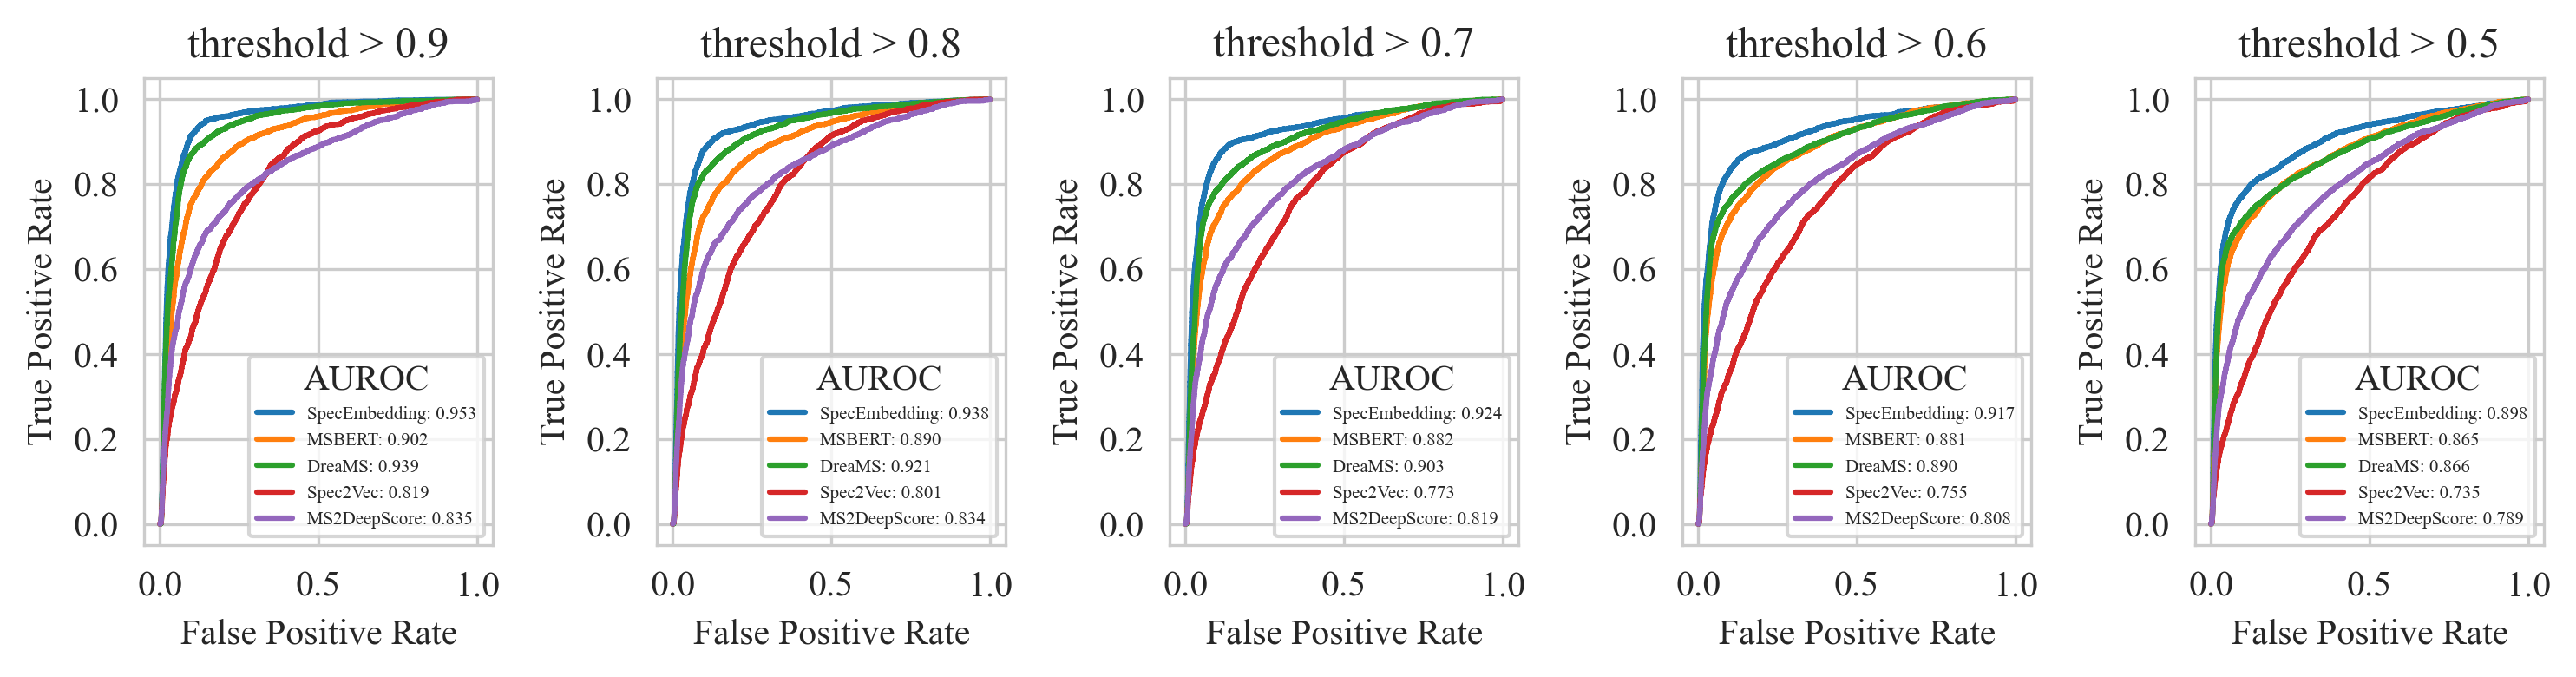

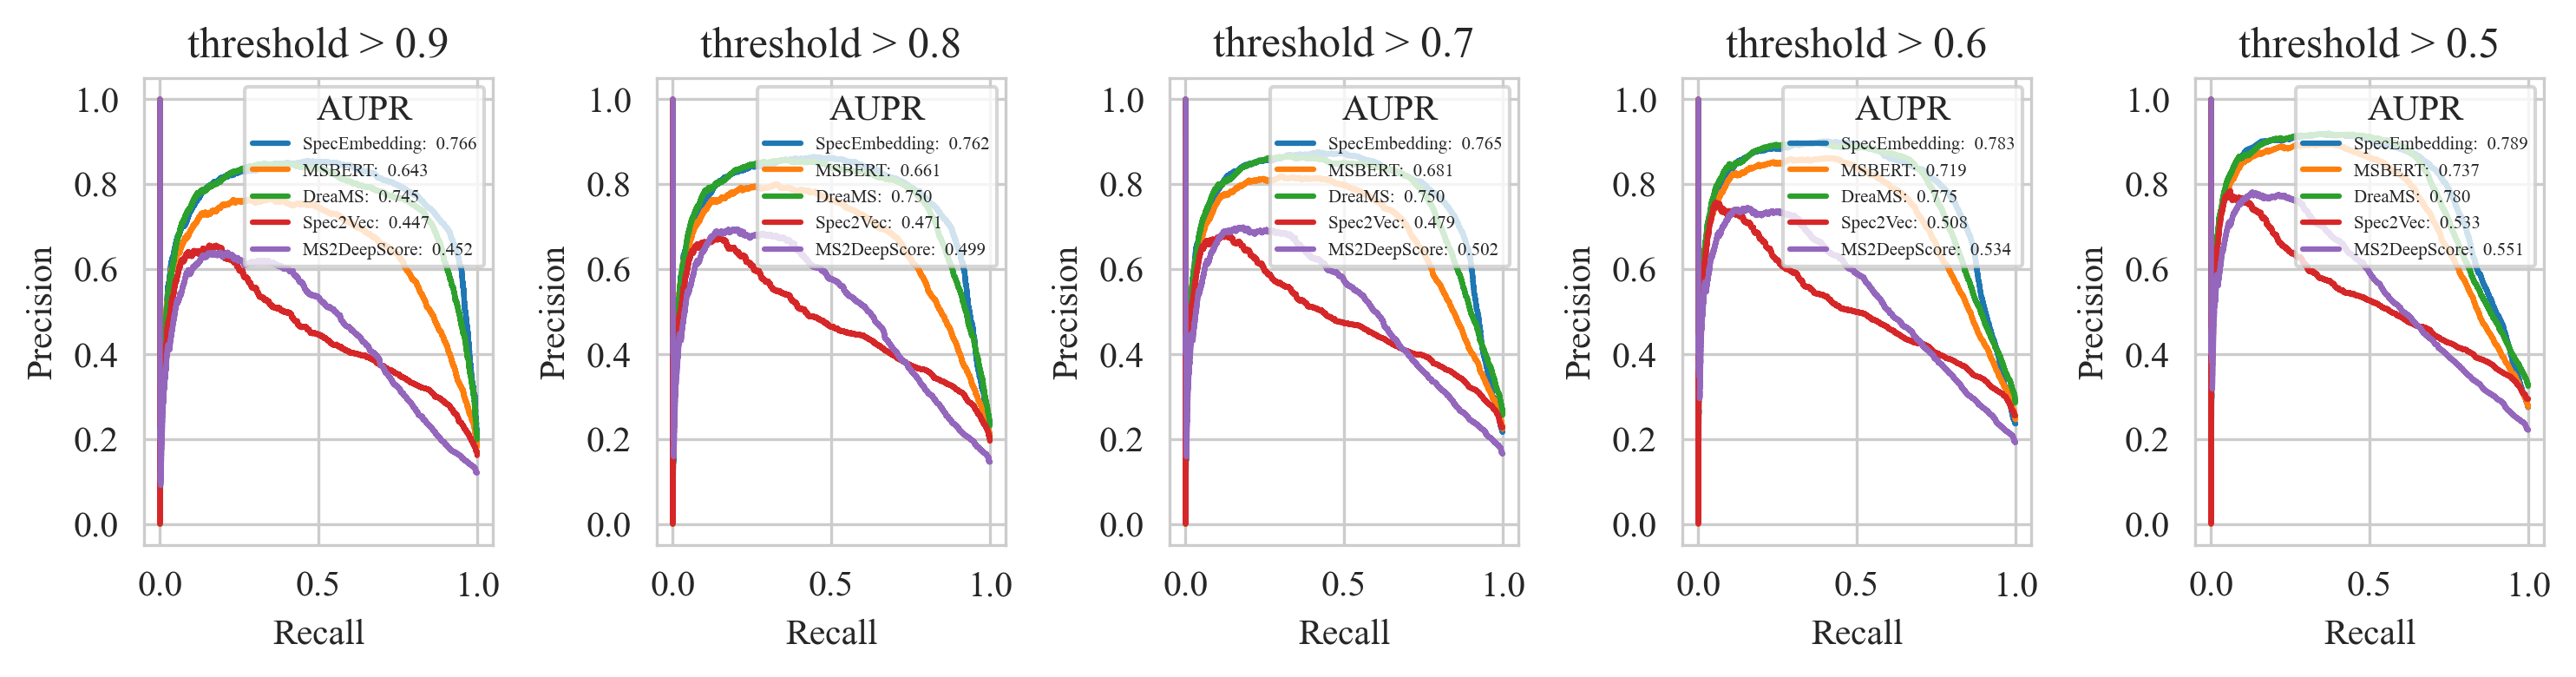

In [5]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve

sns.set_style("whitegrid")
sns.set_palette("tab10")

fm.fontManager.addfont('/usr/share/fonts/truetype/msttcorefonts/times.ttf')
plt.rcParams['font.family'] = 'Times New Roman'

roc_fig, roc_axs = plt.subplots(1, len(thresholds), figsize=(10, 2.7), dpi=300)
pr_fig, pr_axs = plt.subplots(1, len(thresholds), figsize=(10, 2.7), dpi=300)
roc_axs: list[Axes]
pr_axs: list[Axes]
for ax_i, threshold in enumerate(thresholds):
    roc_ax = roc_axs[ax_i]
    pr_ax = pr_axs[ax_i]

    roc_ax.set_title(f"threshold > {threshold}")
    roc_ax.set_xlabel("False Positive Rate")
    roc_ax.set_ylabel("True Positive Rate")

    pr_ax.set_title(f"threshold > {threshold}")
    pr_ax.set_xlabel("Recall")
    pr_ax.set_ylabel("Precision")

    for i in range(len(methods)):
        labels = np.zeros(len(scores[i], ))
        over_threshold_indices = according_tanimoto_scores[i] > threshold
        labels[over_threshold_indices] = 1
        print(f"method: {methods[i]}, threshold: {threshold}, positive: {sum(labels)}, negative: {len(labels) - sum(labels)}")
        fpr, tpr, _ = roc_curve(labels, scores[i])
        auc_roc = roc_auc_score(labels, scores[i])
        roc_ax.step(fpr, tpr, label=f"{methods[i]}: {auc_roc:.3f}")
        roc_ax.legend(loc="lower right", fontsize=5, title="AUROC")
        p, r, t = precision_recall_curve(labels, scores[i])
        auc_pr = auc(r, p)
        pr_ax.step(r, p, label=f"{methods[i]}: {auc_pr: .3f}")
        pr_ax.legend(loc="upper right", fontsize=5, title="AUPR")

roc_fig.tight_layout()
pr_fig.tight_layout()

roc_fig.savefig(SAVE_DIR / "roc.svg", transparent=True, bbox_inches="tight")
roc_fig.savefig(SAVE_DIR / "roc.png", transparent=True, bbox_inches="tight")
roc_fig.savefig(SAVE_DIR / "roc.pdf", transparent=True, bbox_inches="tight")

pr_fig.savefig(SAVE_DIR / "pr.png", transparent=True, bbox_inches="tight")
pr_fig.savefig(SAVE_DIR / "pr.svg", transparent=True, bbox_inches="tight")
pr_fig.savefig(SAVE_DIR / "pr.pdf", transparent=True, bbox_inches="tight")

In [6]:
from pathlib import Path

import numpy as np

ref_spectra = np.load(mona.QTOF_COMMON, allow_pickle=True)
query_spectra = np.load(mona.QTOF_UNIQUE, allow_pickle=True)

dir = Path("/data1/xp/code/specEmbedding/score_distribution/compound search")

qtof_dir = dir / "qtof"
query_smiles_seq = np.array([
    s.get("smiles")
    for s in query_spectra
])
ref_smiles_seq = np.array([
    s.get("smiles")
    for s in ref_spectra
])

query_labels = get_labels(query_smiles_seq, unique_smiles)
ref_labels = get_labels(ref_smiles_seq, unique_smiles)

scores = [
    np.load(qtof_dir / f"{method}_Score.npy", allow_pickle=True)
    for method in methods
]
indices = [
    np.load(qtof_dir / f"{method}_Indices.npy", allow_pickle=True)
    for method in methods
]
scores = np.array(scores)
indices = np.array(indices)

thresholds = [0.95, 0.9, 0.85, 0.8]
qtof_scores, qtof_indices, over_nums = calculate_proportion_over_threshold(
    ref_labels, query_labels, thresholds
)

according_tanimoto_scores = []
for j in range(len(methods)):
    scores_seq = []
    for row, col in enumerate(indices[j]):
        score_row = query_labels[row]
        score_col = ref_labels[col]
        scores_seq.append(tanimoto_scores[score_row][score_col])
    according_tanimoto_scores.append(scores_seq)

according_tanimoto_scores = np.array(according_tanimoto_scores)

process: 100%|██████████| 2/2 [00:00<00:00, 20.27it/s]

79 0.1172106824925816
96 0.142433234421365
126 0.18694362017804153
150 0.22255192878338279


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve

for threshold in [0.8, 0.7, 0.6, 0.5]:
    for i in range(len(methods)):
        labels = np.zeros(len(scores[i],))
        over_threshold_indices = according_tanimoto_scores[i] > threshold
        labels[over_threshold_indices] = 1
        print(f"{methods[i]}, threshold > {threshold}")
        print(roc_auc_score(labels, scores[i]))
        p, r, t = precision_recall_curve(labels, scores[i])
        print(auc(r, p))

SpecEmbedding, threshold > 0.8
nan
0.5
MSBERT, threshold > 0.8
0.8615421002838222
0.4476643455702495
DreaMS, threshold > 0.8
0.8291233283803864
0.004310344827586207
Spec2Vec, threshold > 0.8
0.7057949479940564
0.002512562814070352
MS2DeepScore, threshold > 0.8
nan
0.5
SpecEmbedding, threshold > 0.7
0.18573551263001487
0.0009107468123861566
MSBERT, threshold > 0.7
0.8166877104377105
0.42661245103110307
DreaMS, threshold > 0.7
0.8291233283803864
0.004310344827586207
Spec2Vec, threshold > 0.7
0.7057949479940564
0.002512562814070352
MS2DeepScore, threshold > 0.7
nan
0.5
SpecEmbedding, threshold > 0.6
0.45553899652260305
0.004063533617217206
MSBERT, threshold > 0.6
0.7666842364783296
0.4642131270164831
DreaMS, threshold > 0.6
0.8291233283803864
0.004310344827586207
Spec2Vec, threshold > 0.6
0.7057949479940564
0.002512562814070352
MS2DeepScore, threshold > 0.6
nan
0.5
SpecEmbedding, threshold > 0.5
0.47183551081602054
0.008865140229429812
MSBERT, threshold > 0.5
0.7549987737030297
0.51018825

/data/xp/Anaconda/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/data/xp/Anaconda/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/data/xp/Anaconda/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/data/xp/Anaconda/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/data/xp/Anaconda/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined

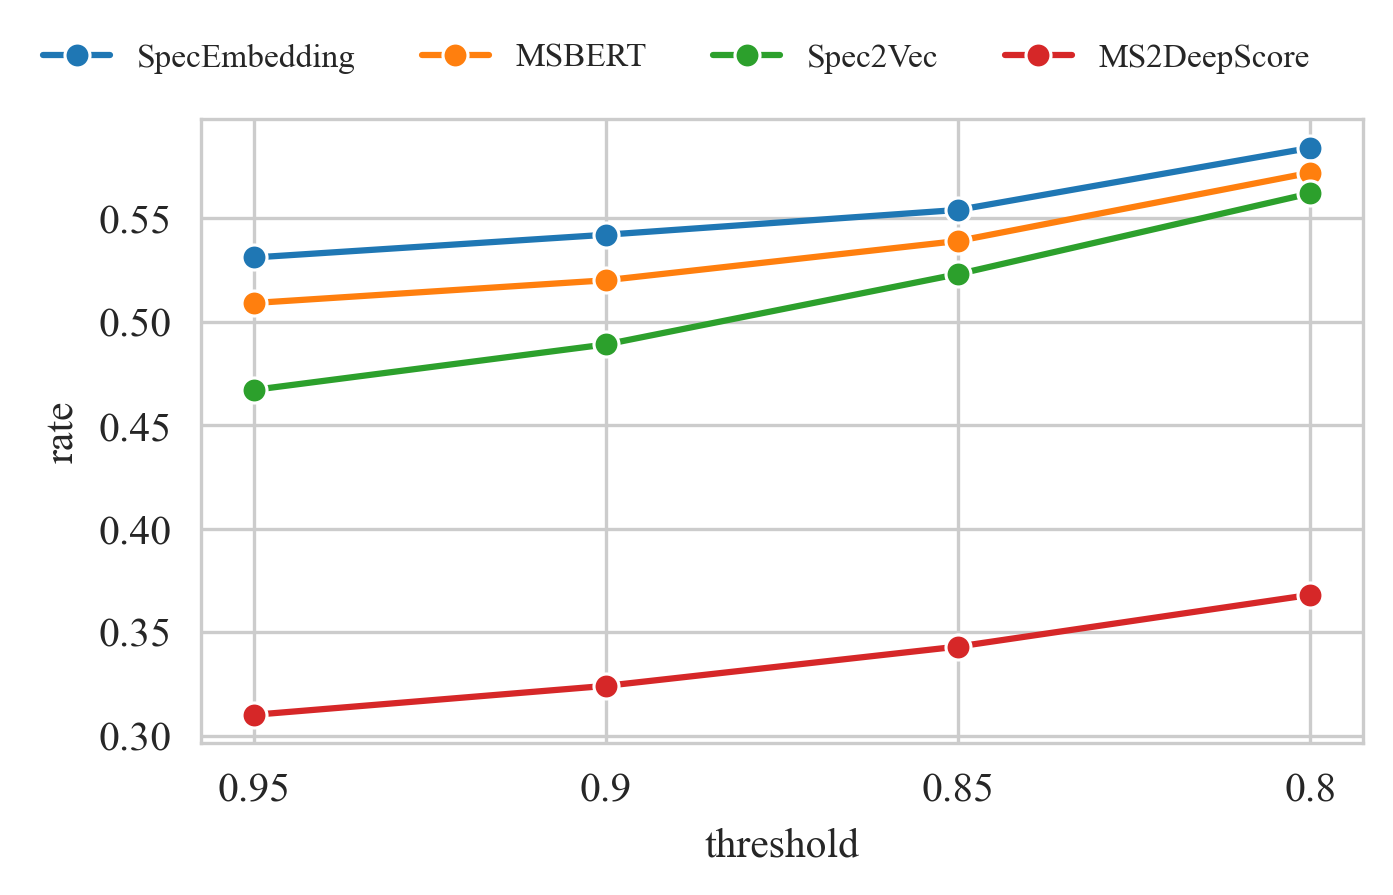

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

sns.set_style("whitegrid")
sns.set_palette("tab10")

fm.fontManager.addfont('/usr/share/fonts/truetype/msttcorefonts/times.ttf')
plt.rcParams['font.family'] = 'Times New Roman'
figure, ax = plt.subplots(1, 1, figsize=(5, 2.7), dpi=300)

x = [f"{threshold}" for threshold in thresholds]

orbitrap_hit = {
    "SpecEmbedding": [0.531, 0.542, 0.554, 0.584],
    "MSBERT": [0.509, 0.520, 0.539, 0.572],
    "Spec2Vec": [0.467, 0.489, 0.523, 0.562],
    "MS2DeepScore": [0.310, 0.324, 0.343, 0.368]
}

df = pd.DataFrame(columns=["method", "threshold", "rate"])
for method, values in orbitrap_hit.items():
    for i in range(len(values)):
        df.loc[len(df)] = [method, x[i], values[i]]

sns.lineplot(data=df, x="threshold", y="rate", hue="method", marker="o", ax=ax)
ax.legend().remove()
figure.legend(loc="lower left", bbox_to_anchor=(0, 0.9), frameon=False, ncol=4, fontsize=8)

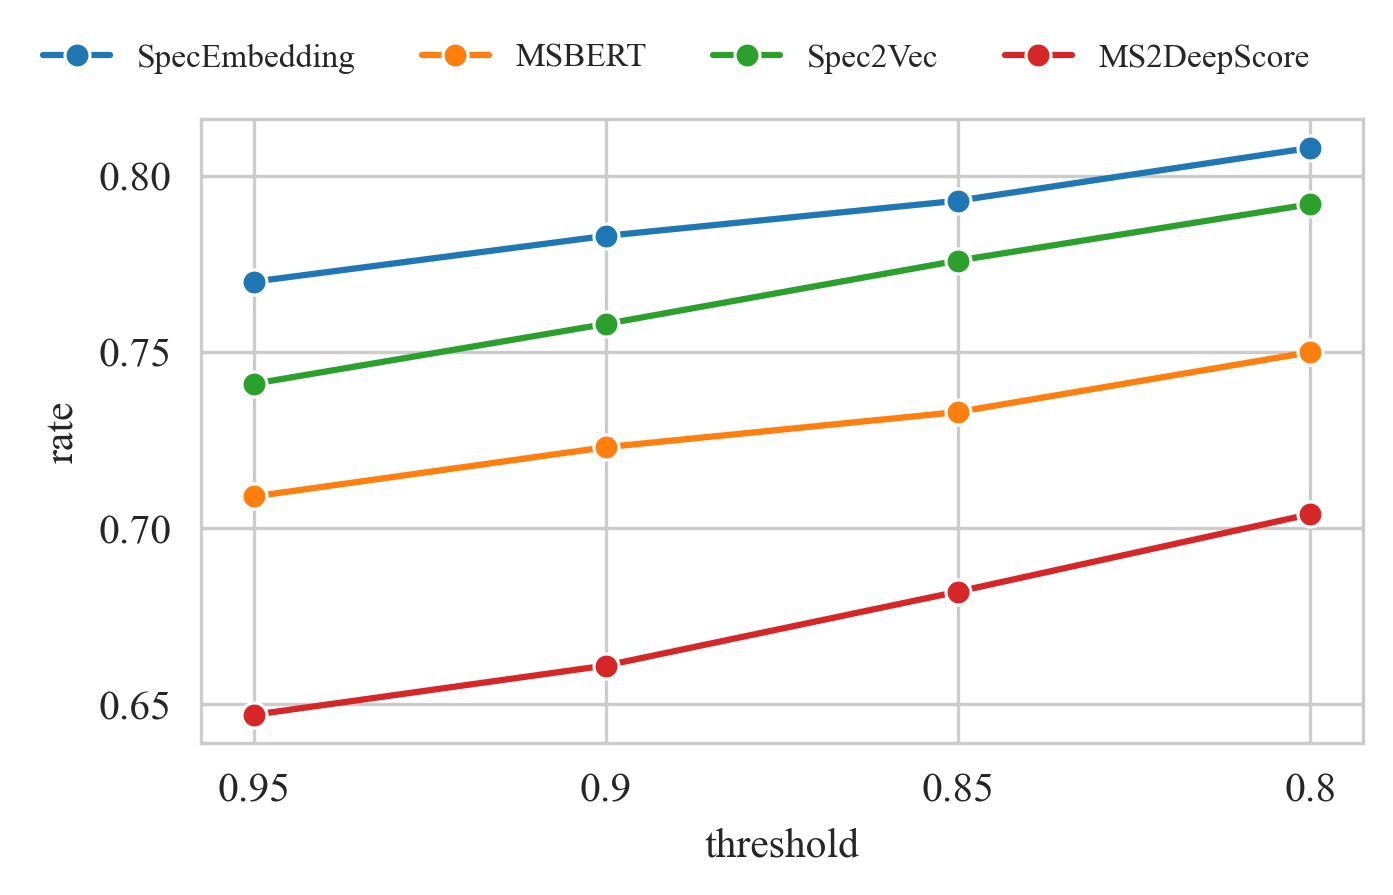

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

figure, ax = plt.subplots(1, 1, figsize=(5, 2.7), dpi=300)

x = [f"{threshold}" for threshold in thresholds]

qtof_hit = {
    "SpecEmbedding": [0.770, 0.783, 0.793, 0.808],
    "MSBERT": [0.709, 0.723, 0.733, 0.750],
    "Spec2Vec": [0.741, 0.758, 0.776, 0.792],
    "MS2DeepScore": [0.647, 0.661, 0.682, 0.704]
}

df = pd.DataFrame(columns=["method", "threshold", "rate"])
for method, values in qtof_hit.items():
    for i in range(len(values)):
        df.loc[len(df)] = [method, x[i], values[i]]

sns.lineplot(data=df, x="threshold", y="rate", hue="method", marker="o", ax=ax)
ax.legend().remove()
figure.legend(loc="lower left", bbox_to_anchor=(0, 0.9), frameon=False, ncol=4, fontsize=8)